# Starting Kit - Relevance 
## Baseline 2: Regressors

This notebooks tries different classic ML regressors, using the relevance_sample_data.csv to perform a grid search for hyperparameter tuning. It alsos proposes different visualizations of the models' performances, like scatters and histograms of residual errors. The idea is to check whether we can use a Regressor for this task, that was originally proposed as a Classification problem.

Here we split the relevance_sample_data dataset into train and test (75% / 25%) and perform a RandomSearch (50 iter.) using 3-fold Cross validation. Therefore, each validation set has the same size of the test set (25% of total data). At the end, we try the best candidate of each model family using the test set and score its performance using R2 score and Kendall's Tau Coefficient.

***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB='google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/ihsaan-ullah/M1-Challenge-Class-2024.git

    # move to the HEP starting kit folder
    %cd M1-Challenge-Class-2024/Relevance/Starting_Kit/

    !pip install -q --upgrade sentence-transformers transformers

***
# Imports
***

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import seaborn as sns

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from scipy.stats import kendalltau

from sklearn.model_selection import RandomizedSearchCV

import torch

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

C:\Users\Paulo Couto\anaconda3\envs\M1_AI-Challenge\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


***
# Directories
***

In [4]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
# Reference data directory to read test labels from
reference_dir = root_dir + "sample_data/"
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [5]:
sys.path.append(input_dir)
sys.path.append(reference_dir)
sys.path.append(output_dir)
sys.path.append(program_dir)
sys.path.append(submission_dir)

***
# Data
***
1. Load Data
2. Preprocess data


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [6]:
class Data():

  def __init__(self):

      self.df = None

      print("==========================================")
      print("Data")
      print("==========================================")

  def load_data(self):
    """
      Loads data from csv file
    """
    print("[*] Loading Data")

    # data file path
    data_file = os.path.join(input_dir, 'relevance_sample_data.csv')
    
    # read data
    self.df = pd.read_csv(data_file)


  def _text_to_dict(self, text):
    """
    Converts a text string into a dictionary.

    :param text: A string representation of a dictionary.
    :return: A dictionary object if conversion is successful, otherwise {}.
    """
    try:
      return ast.literal_eval(text)
    except:
      return {}  # Return an empty dictionary in case of an error
    
  def _dict_to_paragraphs(self, dictionary):
    """
    Converts a dictionary into a string of paragraphs.

    :param dictionary: A dictionary.
    :return: A string composed of paragraphs based on the dictionary's key-value pairs.
    """
    text = ''
    for i, (k, v) in enumerate(dictionary.items()):
        text += k.capitalize() + '\n' + v + '\n'
    return text
  
  def transfrom_data(self):

    print("[*] Transforming Data")
    
    # Convert to dictionary
    self.df['most_relevant_dict'] = self.df['most_relevant'].apply(self._text_to_dict)
    self.df['second_most_relevant_dict'] = self.df['second_most_relevant'].apply(self._text_to_dict)
    self.df['second_least_relevant_dict'] = self.df['second_least_relevant'].apply(self._text_to_dict)
    self.df['least_relevant_dict'] = self.df['least_relevant'].apply(self._text_to_dict)


    # Convert from dictionary to text
    self.df['most_relevant_text'] = self.df['most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_most_relevant_text'] = self.df['second_most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_least_relevant_text'] = self.df['second_least_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['least_relevant_text'] = self.df['least_relevant_dict'].apply(self._dict_to_paragraphs)


  def _get_embeddings(self, text1, text2):
    """
    Generates embeddings for two texts.

    :param text1: First text string.
    :param text2: Second text string.
    :return: Tuple of embeddings for text1 and text2.
    """
    embedding1 = self.embeddings_model.encode(text1, convert_to_tensor=True)
    embedding2 = self.embeddings_model.encode(text2, convert_to_tensor=True)
    return embedding1.cpu(), embedding2.cpu()
  
  def prepare_data(self):

    print("[*] Prepare Data for Training")
    
    model_name = 'paraphrase-MiniLM-L6-v2'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.embeddings_model = SentenceTransformer(model_name, device=device)

    # Create embeddings for each pair
    self.df['most_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['most_relevant_text']), axis=1)
    self.df['second_most_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['second_most_relevant_text']), axis=1)
    self.df['second_least_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['second_least_relevant_text']), axis=1)
    self.df['least_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['least_relevant_text']), axis=1)

    # Label the Data
    self.df['most_relevant_label'] = 3.
    self.df['second_most_relevant_label'] = 2.
    self.df['second_least_relevant_label'] = 1.
    self.df['least_relevant_label'] = 0.

    X = self.df['most_relevant_embeddings'].tolist() + self.df['second_most_relevant_embeddings'].tolist() + self.df['second_least_relevant_embeddings'].tolist() + self.df['least_relevant_embeddings'].tolist()
    y = self.df['most_relevant_label'].tolist() + self.df['second_most_relevant_label'].tolist() + self.df['second_least_relevant_label'].tolist() + self.df['least_relevant_label'].tolist()

    # Convert embeddings from tuples to concatenated arrays
    X = [torch.abs(embeddings[0] - embeddings[1]).numpy() for embeddings in X]

    # Shuffle X and y
    X, y = shuffle(X, y, random_state=42)

    # train test split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  def get_train_data(self):
    return self.X_train, self.y_train
  
  def get_test_data(self):
    return self.X_test, self.y_test
  
  def show_random_sample(self):
    random_sample_index = np.random.randint(0, len(self.df))

    print("Prompt:\n", self.df.iloc[random_sample_index]['prompt'], "...\n")
    print("Most Relevant Text:\n", self.df.iloc[random_sample_index]['most_relevant_text'][:300], "...\n")
    print("Second Most Relevant Text:\n", self.df.iloc[random_sample_index]['second_most_relevant_text'][:300], "...\n")
    print("Second Least Relevant Text:\n", self.df.iloc[random_sample_index]['second_least_relevant_text'][:300], "...\n")
    print("Least Relevant Text:\n", self.df.iloc[random_sample_index]['least_relevant_text'][:300], "...\n")


  def show_data_stats(self):
    print("X_train shape: ", np.shape(self.X_train))
    print("y_train shape: ", np.shape(self.y_train))
    print("X_test shape: ", np.shape(self.X_test))
    print("y_test shape: ", np.shape(self.y_test))
    
  def get_data_viz(self):
    prompt_len = self.df['prompt'].apply(len)
      
    most_relevant_text_len = self.df['most_relevant_text'].apply(len)
    second_most_relevant_text_len = self.df['second_most_relevant_text'].apply(len)
    second_least_relevant_text_len = self.df['second_least_relevant_text'].apply(len)
    least_relevant_text_len = self.df['least_relevant_text'].apply(len)

    texts_len = most_relevant_text_len + second_most_relevant_text_len + second_least_relevant_text_len + least_relevant_text_len
    return prompt_len, texts_len

In [7]:
# Initilaize data
data = Data()

Data


In [8]:
# load data
data.load_data()

[*] Loading Data


In [9]:
# transform data
data.transfrom_data()

[*] Transforming Data


In [10]:
# prepare data
data.prepare_data()

[*] Prepare Data for Training


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
# get train test data
X_train, y_train = data.get_train_data()
X_test, y_test = data.get_test_data()

In [13]:
print("Simple data stats: shape of the train and test sets\n")
data.show_data_stats()

Simple data stats: shape of the train and test sets

X_train shape:  (1600, 384)
y_train shape:  (1600,)
X_test shape:  (400, 384)
y_test shape:  (400,)


In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pca = PCA()

In [15]:
models = [
    ElasticNet(),
    SVR(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor()
]

models_names = [
    "ElasticNet",
    "SVR",
    "KNN",
    "Gradient Boosting",
    "Random Forest"
]

parameters = [
    {'model__l1_ratio':[0., 0.25, 0.5, 0.75, 1.], 'model__alpha':[0.5, 1, 2], 'model__selection':('cyclic', 'random'), 'pca__n_components':[None, 10, 50, 100]},
    {'model__kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'model__gamma':('scale', 'auto'), 'model__C':[1, 10], 'pca__n_components':[None, 10, 50, 100]},
    {'model__n_neighbors':[3, 5, 10], 'model__weights':('uniform', 'distance'), 'model__algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'pca__n_components':[None, 10, 50, 100]},
    {'model__loss':('squared_error', 'absolute_error', 'huber'), 'model__learning_rate':[0.01, 0.1, 0.5], 'model__n_estimators':[50, 100, 150], 'model__criterion':('friedman_mse', 'squared_error'), 'pca__n_components':[None, 10, 50, 100]},
    {'model__n_estimators':[50, 100, 150], 'model__criterion':('friedman_mse', 'squared_error', 'absolute_error', 'poisson'), 'model__max_depth':[None, 5, 10, 20], 'pca__n_components':[None, 10, 50, 100]}
]

In [16]:
best_models = []
kendalls_tau = []

Model:  ElasticNet
Best Hyperparameters: {'pca__n_components': 100, 'model__selection': 'cyclic', 'model__l1_ratio': 0.0, 'model__alpha': 0.5}
R2 Score on Test Set:  0.654
Kendall's Tau on Test Set:  0.706


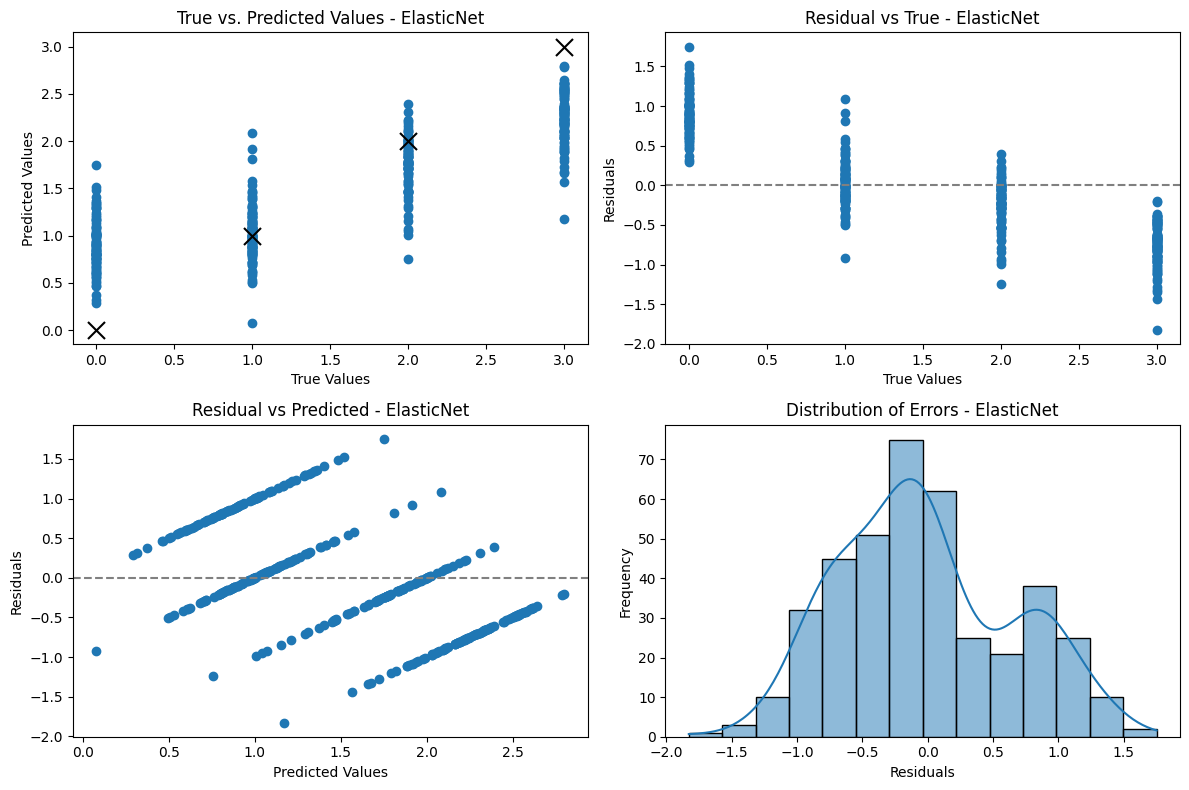


################################################################################

Model:  SVR
Best Hyperparameters: {'pca__n_components': None, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 1}
R2 Score on Test Set:  0.772
Kendall's Tau on Test Set:  0.702


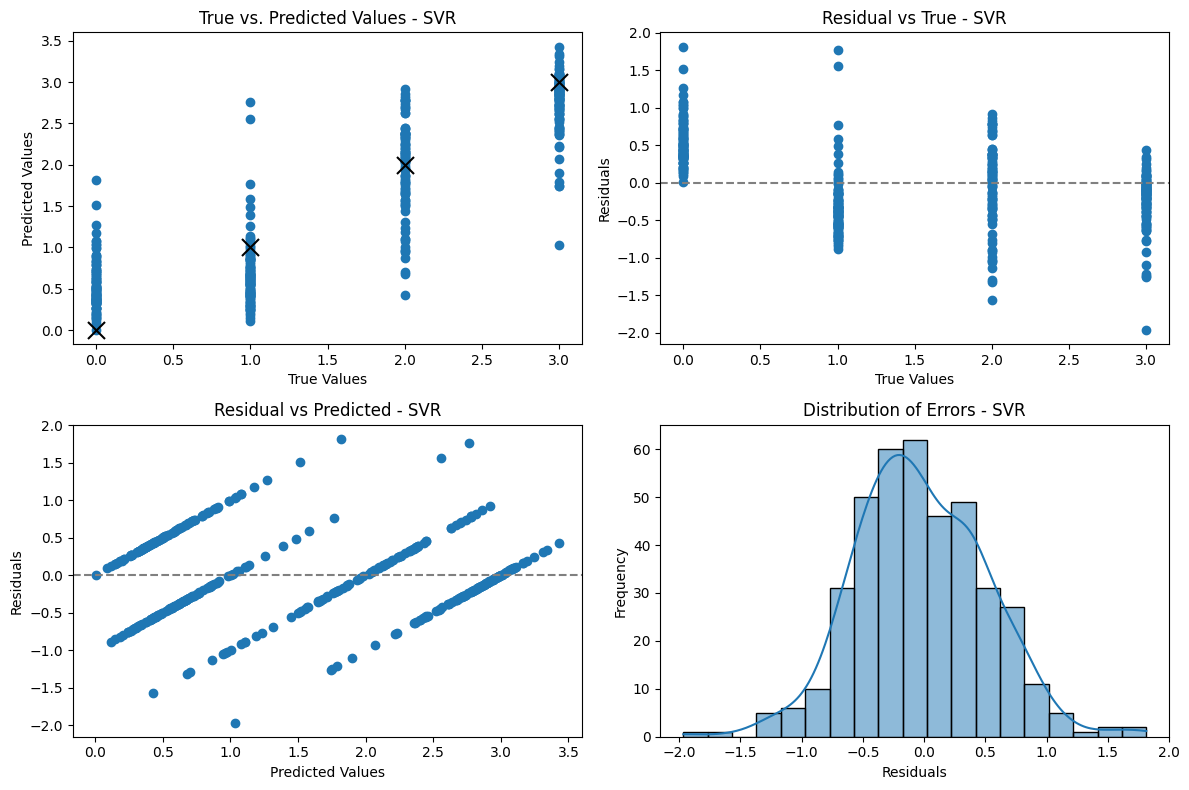


################################################################################

Model:  KNN
Best Hyperparameters: {'pca__n_components': 10, 'model__weights': 'distance', 'model__n_neighbors': 10, 'model__algorithm': 'ball_tree'}
R2 Score on Test Set:  0.756
Kendall's Tau on Test Set:  0.676


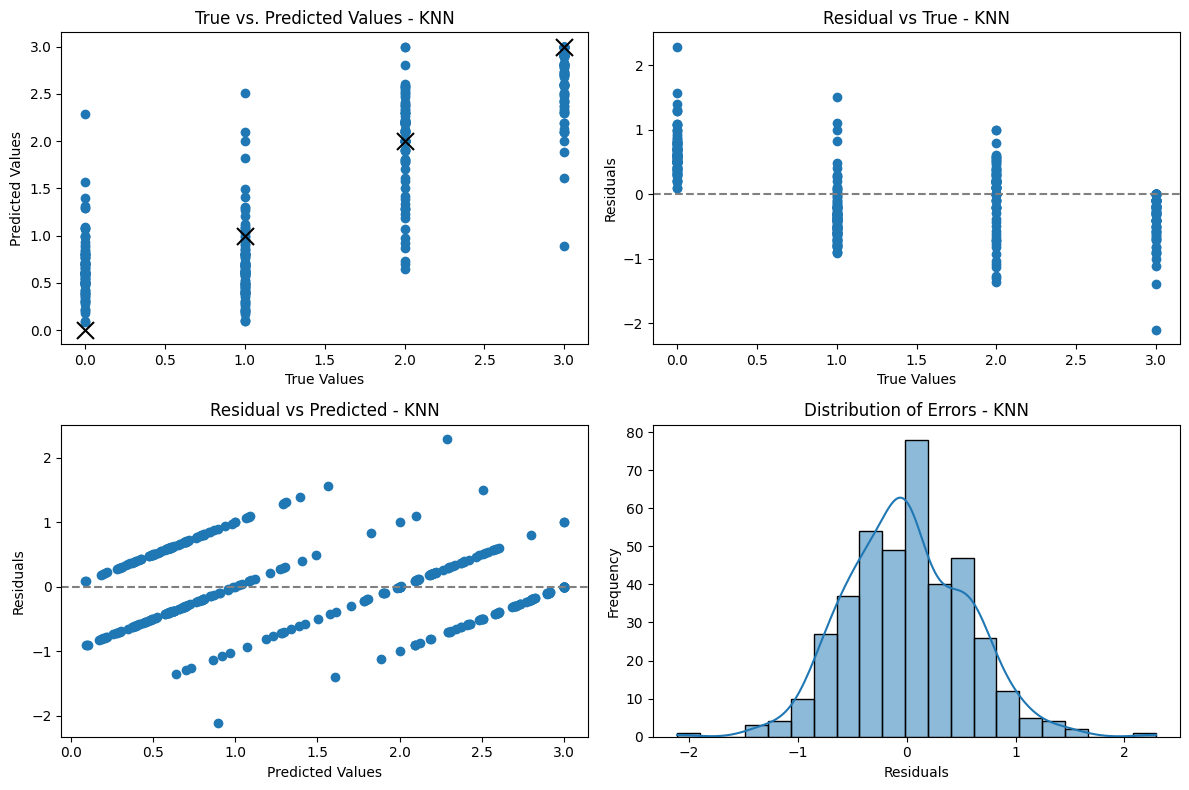


################################################################################

Model:  Gradient Boosting
Best Hyperparameters: {'pca__n_components': 50, 'model__n_estimators': 50, 'model__loss': 'squared_error', 'model__learning_rate': 0.1, 'model__criterion': 'friedman_mse'}
R2 Score on Test Set:  0.772
Kendall's Tau on Test Set:  0.696


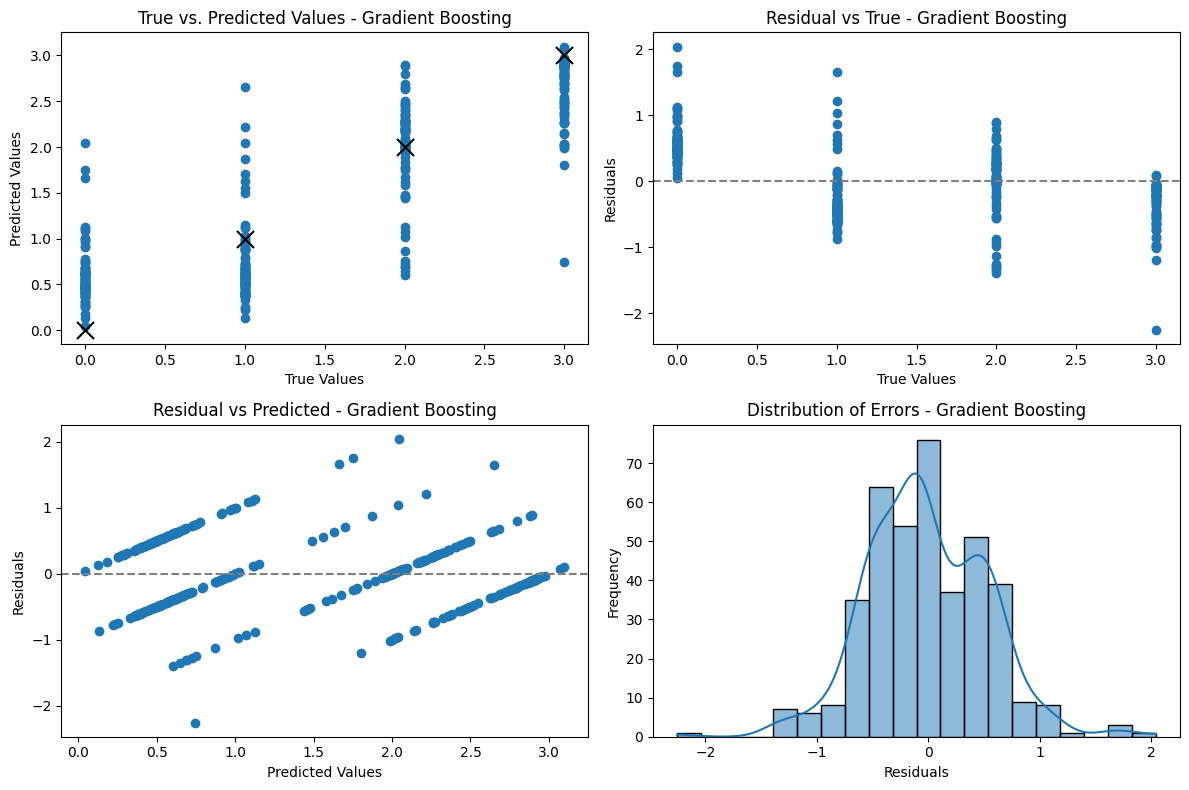


################################################################################

Model:  Random Forest
Best Hyperparameters: {'pca__n_components': 10, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__criterion': 'friedman_mse'}
R2 Score on Test Set:  0.773
Kendall's Tau on Test Set:  0.699


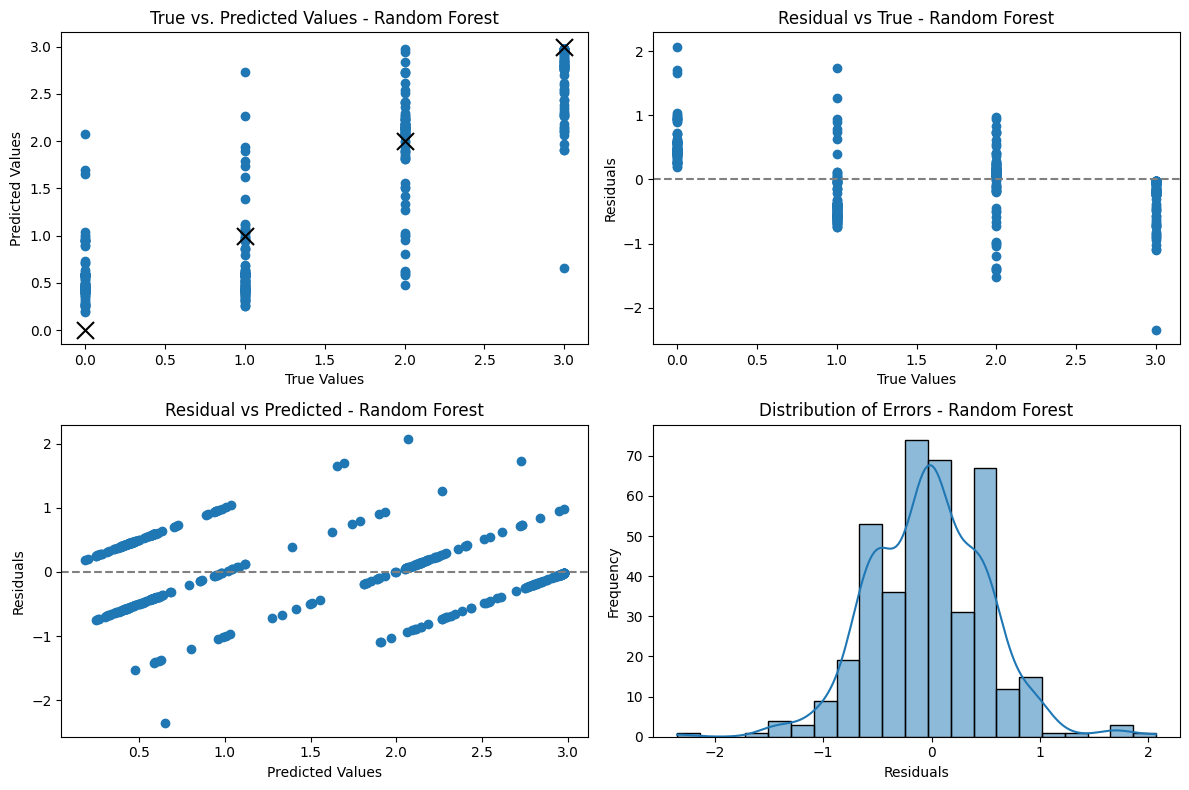


################################################################################



In [32]:
for i, model in enumerate(models):
    pipeline = Pipeline([
        ('pca', pca),
        ('model', model)
    ])
    param_distributions = parameters[i]
    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                     scoring='r2', cv=3, n_iter=50, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Model: ", models_names[i])
    print("Best Hyperparameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_test_hat = best_model.predict(X_test)
    residuals = y_test_hat - y_test
    r2 = r2_score(y_test, y_test_hat)
    print("R2 Score on Test Set: ", round(r2, 3))
    k_tau, _ = kendalltau(y_test, y_test_hat)
    print("Kendall's Tau on Test Set: ", round(k_tau, 3))
    best_models.append(best_model)
    kendalls_tau.append(k_tau)

    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Scatter Plot of True vs. Predicted Values
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_test_hat)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs. Predicted Values - ' + models_names[i])
    plt.scatter(0, 0, color='black', marker='x', s=150)
    plt.scatter(1, 1, color='black', marker='x', s=150)
    plt.scatter(2, 2, color='black', marker='x', s=150)
    plt.scatter(3, 3, color='black', marker='x', s=150)

    # Residual Plot vs truth
    plt.subplot(2, 2, 2)
    plt.scatter(y_test, residuals)
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('Residual vs True - ' + models_names[i])
    plt.axhline(y=0, color='grey', linestyle='--')

    # Residual Plot vs predicted
    plt.subplot(2, 2, 3)
    plt.scatter(y_test_hat, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual vs Predicted - ' + models_names[i])
    plt.axhline(y=0, color='grey', linestyle='--')
    
    # Distribution of Errors Plot
    plt.subplot(2, 2, 4)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Errors - ' + models_names[i])
    
    plt.tight_layout()
    plt.show()
    print("\n################################################################################\n")

In [33]:
idx = kendalls_tau.index(max(kendalls_tau))
print(f"Highest Kendall's Tau: {round(kendalls_tau[idx], 3)}")
print(best_models[idx])
best_models[idx]

Highest Kendall's Tau: 0.706
Pipeline(steps=[('pca', PCA()), ('model', ElasticNet(alpha=0.5, l1_ratio=0.0))])


Pipeline(steps=[('pca', PCA()), ('model', ElasticNet(alpha=0.5, l1_ratio=0.0))])